## **Preparing data for Machine learning**

### **Goal**:
You are the data scientist assigned to perform the data pre-processing and preparing the data for Machine Learning algorithms.

1. Perform data exploration to understand the data
2. Prepare the test and training sets.
3. Pre-processing of the data, including fixing all the missing values (set the missing values to median values) and any other ones that you think are appropriate to perform. Build a pipeline to perform data transformation. (5 points)

In the next hands-on, we will use 14 out of 15 attributes as pedictors describe below to predict if income goes above or below \$50K/yr based on census data. `Income` will be the label.

Dataset is from [UCI](https://archive.ics.uci.edu/dataset/2/adult)

### Data:
An individual’s annual income results from various factors. Intuitively, it is influenced by the individual’s education level, age, gender, occupation, and etc.

### Fields:
The dataset contains 15 columns

#### Target field: Income
- The income is divide into two classes: 50K

#### Number of attributes: 14
-- These are the demographics and other features to describe a person

We can explore the possibility in predicting income level based on the individual’s personal information

- `age`: continuous.
- `workclass`: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- `fnlwgt`: continuous.
- `education`: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- `education-num`: continuous.
- `marital-status`: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- `occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- `relationship`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- `race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- `sex`: Female, Male.
- `capital-gain`: continuous.
- `capital-loss`: continuous.
- `hours-per-week`: continuous.
- `native-country`: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- `salary`: >50K,<=50K

Note: "?" is used to represent missing data in this dataset.

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Read in data. Consider that "?" is used in place of na
adults_fp = 'https://raw.githubusercontent.com/csbfx/advpy122-data/master/adult.csv'


## Part 1: Data Exploration
Let's examine the data. What are some ways to look at the different attribute in the dataframe? What are some good way to quickly get a feel of the type of data you are dealing with? Examples we have used in class includes looking at relationship/correlation and histograms.

In [2]:
adults_fp_read = pd.read_csv(adults_fp, na_values=' ?')
adults_fp_read.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
print((adults_fp_read['workclass'] == 'Never-worked').sum())

# Upon inspecting this dataset, i have come to find out that my initial models were
# not performing well and over-fitting due to the presence of missing values and my decision to just convert them
# into 'unknown' vallues. I realized that the most missing values were contained within the 
# 'workclass' and 'occupation' columns (both of which were missing in about 5% of the rows and I couldn't find much
# correlation between these categories and any tohers to make any educated approximations as replacements).
# Therefore, I made the executive decision to drop these rows with missing values entirely
# and re-ran my models.

# For example, my previous values for Linear regression were RMSE = 0.34010468551275524 and R-squared = 0.3648858835068296
# and my Decision Tree Regressor were RMSE = 0.007998925016711777 and R-squared = 0.9996486905866577 (indicating overfitting).

In [24]:
adults_fp_read_processed = adults_fp_read.copy()

mask_both_missing = (
    (adults_fp_read_processed['workclass'] == '?') &
    (adults_fp_read_processed['occupation'] == '?')
)

adults_fp_read_processed = adults_fp_read_processed[~mask_both_missing]

adults_fp_read_processed['workclass'] = adults_fp_read_processed['workclass'].replace('?', 'unknown')
adults_fp_read_processed['occupation'] = adults_fp_read_processed['occupation'].replace('?', 'unknown')

dropped_count = mask_both_missing.sum()
print("Number of rows where both workclass and occupation were '?':", dropped_count)


Number of rows where both workclass and occupation were '?': 2799


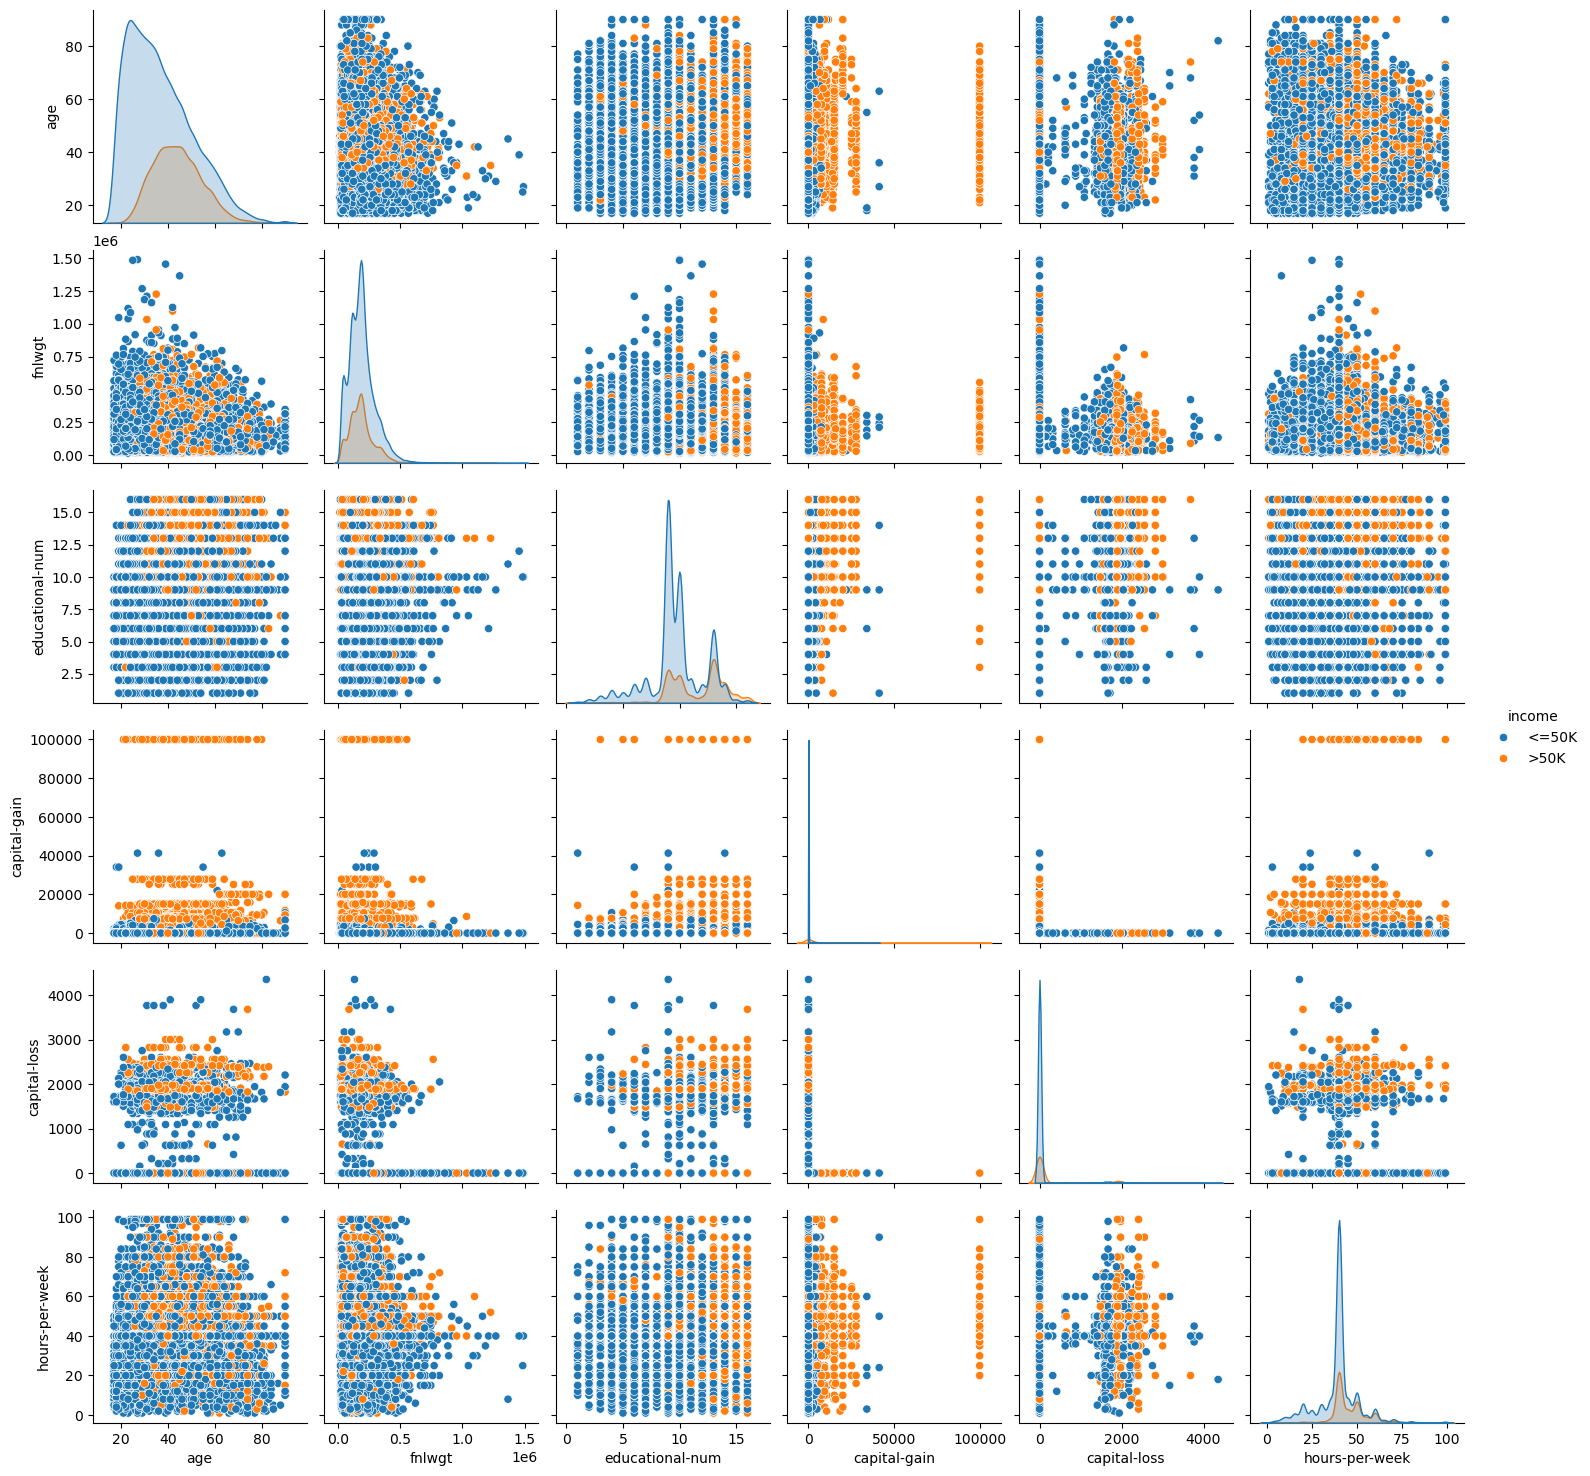

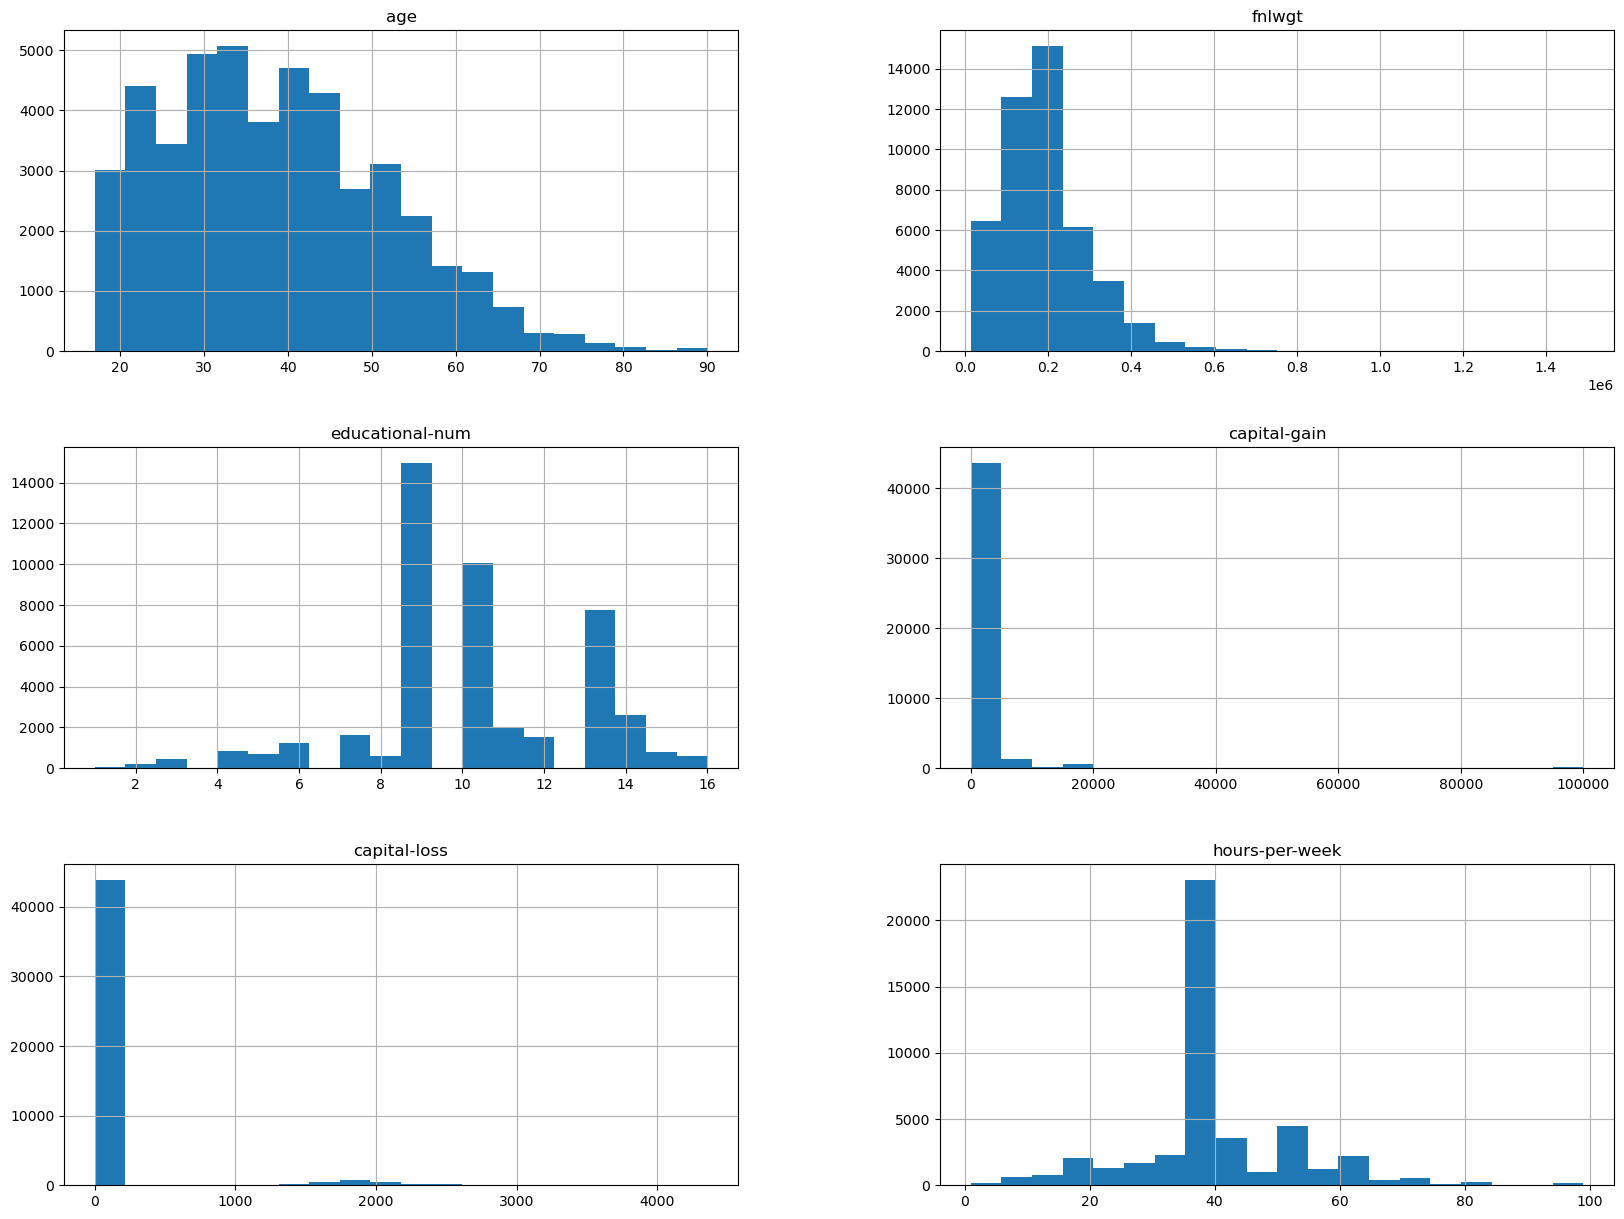

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
adults_fp_read_processed.hist(bins=20, figsize=(20,15))
plt.show()

In [6]:
import seaborn as sns
sns.pairplot(adults_fp_read_processed, hue='income')

## Part 2: Prepare Training & Testing data sets
We next want to create a test set. Set aside 20% of the dataset. To reduce the risk of sampling bias, consider using stratified sampling. For example consider the `income` where we create 5 stratas ranging from \$0 to \$15,000 (take a look at the income data and consider how to bin to reflect the income in \$USD).

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# 2 ML models to make a prediction on whether an individual was a high earner (>50K) or not (<=50K)

# Since the 'income' column can not be split into 5 strata due to it being binary, we are using 'educational-num' which
# has some correlation with income and a good distribution of values.

In [9]:
df = adults_fp_read_processed.copy()
df.reset_index(drop=True, inplace=True)

df['edu_strata'] = pd.cut(
    df['educational-num'],
    bins=5,   
    labels=False
)

df['income'] = df['income'].str.strip().map({ '<=50K': 0, '>50K': 1 })

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["edu_strata"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# Drop the 'edu_strata' column as it was only needed for stratified splitting
for set_ in (strat_train_set, strat_test_set):
    set_.drop("edu_strata", axis=1, inplace=True)

# xt_labels = strat_train_set['income'].copy()

# Separate features and target variable
X_train = strat_train_set.drop('income', axis=1)
y_train = strat_train_set['income']
X_test = strat_test_set.drop('income', axis=1)
y_test = strat_test_set['income']


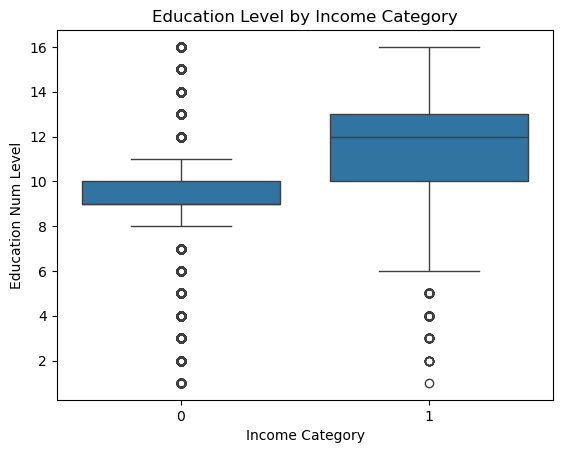

In [10]:
sns.boxplot(
    data=df,
    x="income",
    y="educational-num"
)

plt.title("Education Level by Income Category")
plt.xlabel("Income Category")
plt.ylabel("Education Num Level")
plt.show()

# The below plot visualizes why I chose to stratify based on 'educational-num' 
# instead of 'income' as 'income' is binary and would not provide enough strata for stratified sampling.
# The 'educational-num' column has adequate distribution across a predictable range that still reads
# correlation with income levels.

## Part 3: Pre-processing data

Once we have our training and testing dataset, clean up your dataframe if there are redundant attributes or features that would not be useful in machine learning models such as unique identifiers.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# y_train['income'] = y_train['income'].str.strip().map({ '<=50K': 0, '>50K': 1 })

train_num = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
train_cat = ['workclass', 'education', 'marital-status', 
             'occupation', 'relationship', 'race', 'native-country']

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), train_cat),
        ('num', StandardScaler(), train_num)
    ]
)
X_train_prepared = preprocessing.fit_transform(X_train)
X_test_prepared = preprocessing.transform(X_test)



It is a good idea to further investigate your attributes by using correlation matrix and Seaborn pairplot to understand how different attributes are related.

**Feature engineering**-   
It is useful for ML algorithms to prepare data in meaningful ways. For example, it could be useful to look at the total number of rooms relative to each household. Similarly, the total number of bedrooms is not as meaninful as the number of bedrooms relative to the total number of rooms. Another interesting attribute could be the population per household

## Part 4: ML models
Select two ML Model to make prediction on housing price. Explain why you selected these two models. Perform 10-fold Cross Validation.

In [12]:
# 2 ML models to make a prediction on whether an individual was a high earner (>50K) or not (<=50K)
# # I will use Logistic Regression, Decision Trees, and Random Forests

# Linear Regression Model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

income_predictions = lin_reg.predict(X_train_prepared)
lin_mse = mean_squared_error(y_train, income_predictions)
# root mean squared error
print("lin_rmse:", np.sqrt(lin_mse))

# Mean Asolute Error
from sklearn.metrics import mean_absolute_error
print("lin_mae:", mean_absolute_error(y_train, income_predictions))
print("R-squared for Linear Regression:", r2_score(y_train, income_predictions))

lin_rmse: 0.34427647181910304
lin_mae: 0.2680433736580534
R-squared for Linear Regression: 0.36441786951141475


In [14]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, X_train_prepared, y_train,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

Scores: [0.34470051 0.34762564 0.34614054 0.3453792  0.34217132 0.34245978
 0.34764506 0.3442495  0.34770056 0.34310083]
Mean: 0.34511729324585366
Standard deviation: 0.0020298838570646776


In [15]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train_prepared, y_train)
dtr_pred = dtr.predict(X_train_prepared)

In [16]:
dtr_mse = mean_squared_error(y_train, dtr_pred)
print("RMSE for Decision Tree Regressor:", np.sqrt(dtr_mse))
print("Decision Tree R-squared:", r2_score(y_train, dtr_pred))

# Low RMSE and high R-squared

RMSE for Decision Tree Regressor: 0.007368694577119062
Decision Tree R-squared: 0.9997088357143817


In [17]:
scores = cross_val_score(dtr, X_train_prepared, y_train,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

# The standard deviation continues to be pretty low, indicating relatively consistent model performance across different folds.


Scores: [0.43784402 0.43559088 0.44216241 0.43877297 0.42171572 0.43126521
 0.43565001 0.43906449 0.43813591 0.43565001]
Mean: 0.4355851625731234
Standard deviation: 0.005368133996256638


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(X_train_prepared, y_train)
for_predictions = forest_reg.predict(X_train_prepared)
forest_mse = mean_squared_error(y_train, for_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

# RMSE is even lower than Decision Tree Regressor, indicating best performance.

np.float64(0.14034902075071276)

In [38]:
scores = cross_val_score(forest_reg, X_train_prepared, y_train,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

print("Random forest R-Squared:", r2_score(y_train, for_predictions))

Scores: [0.31709979 0.32253757 0.32451183 0.32095507 0.31650024 0.31960494
 0.32395804 0.32382102 0.32747373 0.32159942]
Mean: 0.32180616426416725
Standard deviation: 0.0032339198019853783
Random forest R-Squared: 0.8943728006629862


## Part 5: Fine-tune your model
Pick the best model from Part 4 and perform fine-tuning. Use the fine-tuned model and evaluate its performance using the test set. How does the fine tune compared to your original evaluation in Part 4.

In [33]:
# I chose the Random Forest Regressor for hyperparameter tuning using RandomizedSearchCV as it showed the better performance.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=100),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                random_state=42)
rnd_search.fit(X_train_prepared, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002254D0A9370>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000225456E7E10>},
                   random_state=42, scoring='neg_mean_squared_error')

In [34]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.3302256690663088 {'max_features': 7, 'n_estimators': 29}
0.32828510724890914 {'max_features': 7, 'n_estimators': 43}
0.3336609225594595 {'max_features': 5, 'n_estimators': 21}
0.33222256074353923 {'max_features': 7, 'n_estimators': 19}
0.3369898101598644 {'max_features': 7, 'n_estimators': 11}
0.3356951031296353 {'max_features': 3, 'n_estimators': 24}
0.33092212160711776 {'max_features': 5, 'n_estimators': 36}
0.33598503446372413 {'max_features': 3, 'n_estimators': 22}
0.3961744494917615 {'max_features': 5, 'n_estimators': 2}
0.3338675265892946 {'max_features': 4, 'n_estimators': 30}


In [35]:
feature_importances = rnd_search.best_estimator_.feature_importances_
cat_encoder = preprocessing.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = train_num + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

# The results below show that the most important feature to predict income seems to be 
# 'capital-gain' followed by 'hours-per-week' and 'capital-loss'. However, I have decided to not remove
# any features as all features seem to contribute to the model to a similar degree.  

[(np.float64(0.009607802291555922), 'capital-gain'),
 (np.float64(0.007881657688320918), 'hours-per-week'),
 (np.float64(0.006256665672882223), 'capital-loss'),
 (np.float64(0.0056326256255656735), 'fnlwgt'),
 (np.float64(0.004651821136842372), 'age'),
 (np.float64(0.004191675627225291), 'Federal-gov'),
 (np.float64(0.0024285305571048427), 'Private'),
 (np.float64(0.0019901323822526158), 'Never-worked'),
 (np.float64(0.0019742288934862856), 'Without-pay'),
 (np.float64(0.0008487768222119495), 'Self-emp-inc'),
 (np.float64(0.0008072387704659672), 'State-gov'),
 (np.float64(0.0004120941037994347), 'Self-emp-not-inc'),
 (np.float64(0.0001486802192532028), 'Local-gov'),
 (np.float64(2.880684689278746e-06), 'educational-num')]

In [36]:
# Final Model Evaluation on Test Set: 

final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop('income', axis=1)
y_test = strat_test_set['income'].copy()

X_test_prepared = preprocessing.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

np.float64(0.32804966558256227)

In [40]:
print("Random forest R-Squared:", r2_score(y_test, final_predictions))

Random forest R-Squared: 0.4236593190241549


In [ ]:
dtr_scores = cross_val_score(final_model, X_train_prepared, y_train,
                        scoring="neg_mean_squared_error", cv=10)
dtr_rmse_scores = np.sqrt(-dtr_scores)

display_scores(dtr_rmse_scores)

# As expected, the final model using the test data performs similarly and actually a bit better
# with respect to RMSE and R-squared (which is significantly better after hyperparameter tuning) values using the Random Forest model
# than during cross-validation, indicating that the model generalizes well to unseen data as well.

Scores: [0.32173263 0.33004567 0.33054323 0.32683203 0.32254332 0.32126585
 0.33391726 0.33108988 0.33506449 0.33032173]
Mean: 0.3283356076808387
Standard deviation: 0.0047450341867165905


## Bonus: Evaluating the model using the Confusion Matrix and a Precision-Recall Curve
A confusion matrix is a tabular summary of the number of correct and incorrect predictions made by a classifier. It can be used to evaluate the performance of a classification model through the calculation of performance metrics such as [accuracy, precision, recall, and F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html). Here is [an article](https://medium.com/swlh/explaining-accuracy-precision-recall-and-f1-score-f29d370caaa8) that gives a good explaination of Precision, Recall, and F1-score.

#### **Accuracy**
   
Accuracy = $\frac{True\ Positives\ +\ True\ Negatives}{All\ Samples}$

**Precision (aka Specificity)**

Precision = $\frac{True\ Positives}{True\ Positives\ +\ False\ Positives}$
= $\frac{True\ Positives}{Total\ Predicted\ Positives}$


**Recall (aka Sensitivity)**

Recall = $\frac{True\ Positives}{True\ Positives\ +\ False\ Negatives}$
= $\frac{True\ Positives}{Total\ Actual\ Positives}$

**F1-score (combining Precision and Recall)**

F1-score = $\frac{2\ ×\ (Precision\ ×\ Recall)}{Precision\ +\ Recall}$

In [ ]:
# Your code here . . .

#### **Precision-Recall Curve**
[Precision-Recall Curve documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py)


In [ ]:
# Your code here . . .
